This file is part of BrainMolecularAtlas.

Copyright (c) 2021 Blue Brain Project/EPFL 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt

import timeit
import numpy as np
from collections import Counter

from numpy.random import seed
from numpy.random import randint
from scipy.stats import ks_2samp
from scipy.stats import levene
from scipy.stats import fligner
from scipy.stats import kruskal
import scikit_posthocs as sp

import scipy.stats as ss
from scipy.stats import mannwhitneyu


import pickle as pkl



pd.options.display.max_columns = None
pd.options.display.max_rows = None


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
sns.set_style('whitegrid',{'axes.grid':False})

In [3]:
with open('../data/6_df_processed.pkl','rb') as f:
    df = pkl.load(f)
print(len(df))
df["log_conc_uM_medNorm"]  = df["log_conc_uM_medNorm"].astype('float64')

df = df.reset_index(drop=True)

df['exp_conc'] = np.exp(df['log_conc_uM_medNorm'])


custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}   

2131244


In [4]:
len(df['gene_id_final'].unique())

14700

In [5]:
# Peptides manually obtained from Uniprot
peps_uniprot_annot = pd.read_csv('../data/uniprot_peptides_rev_rat_human_mouse_04_03_2019_annotatedAsPeptidesType.tab',sep='\t')
print(len(peps_uniprot_annot))

peps_uniprot_annot.head()

427


,Entry,Entry name,Status,Protein names,Gene names,Organism,Length
0,P01024,CO3_HUMAN,reviewed,Complement C3 (C3 and PZP-like alpha-2-macrogl...,C3 CPAMD1,Homo sapiens (Human),1663
1,P01027,CO3_MOUSE,reviewed,Complement C3 (HSE-MSF) [Cleaved into: Complem...,C3,Mus musculus (Mouse),1663
2,P01026,CO3_RAT,reviewed,Complement C3 [Cleaved into: Complement C3 bet...,C3,Rattus norvegicus (Rat),1663
3,Q8CIE6,COPA_MOUSE,reviewed,Coatomer subunit alpha (Alpha-coat protein) (A...,Copa,Mus musculus (Mouse),1224
4,P53621,COPA_HUMAN,reviewed,Coatomer subunit alpha (Alpha-coat protein) (A...,COPA,Homo sapiens (Human),1224


In [6]:
peps_uniprot_annot["Gene names"] = peps_uniprot_annot["Gene names"].str.upper()

In [7]:
print(len(peps_uniprot_annot["Gene names"].unique()))

269


In [8]:
peps_uniprot_annot["Gene names"].unique()[0].split(" ")

['C3', 'CPAMD1']

In [9]:
peps_ann = []

for pep in peps_uniprot_annot["Gene names"].unique():
    #pep = pep.str.upper()
    if type(pep) == str:
        peps_ann.extend(pep.upper().split(" "))
    elif np.isnan(pep) == False:
        print(pep)
    else:
        print("nan")
        
peps_ann_s = list(set(peps_ann))
print(len(peps_ann_s))
#peps_ann_s

nan
440


In [10]:
peps_ann2 = []

for pep in peps_uniprot_annot["Entry"].unique():
    #pep = pep.str.upper()
    if type(pep) == str:
        peps_ann2.extend(pep.upper().split(" "))
    elif np.isnan(pep) == False:
        print(pep)
    else:
        print("nan")
        
peps_ann_s2 = list(set(peps_ann2))
print(len(peps_ann_s2))
#peps_ann_s

427


In [11]:
df_pep_annG = df[df['gene_id_final'].isin(peps_ann_s)]
print(len(df_pep_annG))
print(len(df_pep_annG['gene_id_final'].unique()))
df_pep_annG.head()

12531
86


,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,TheorPepNum,conc_uM,log_conc_uM,copyNum,totalProtein,totalVolume,sample_full_id,compound_gene_protein_id,row_id,row_gene_id,gene_id_dd,log_conc_uM_medNorm,exp_conc
32,TMPO,Q61033,Itzhak 2017,mouse,nucleus,embr,15,NaN,NaN,75.167,2060.876095,Median cellular concentration [nM],TMPO,Q61029,TMPO,7.630886,"[P42167, Q62733, Q61033, P42166, Q61029]",Q61033,None,2.06088,0.723131,None,None,None,Itzhak 2017_mouse_nucleus_15_nan_nan,TMPO#Q61033,TMPO#Q61033@Itzhak 2017_mouse_nucleus_15_nan_nan,TMPO@Itzhak 2017_mouse_nucleus_15_nan_nan,TMPO,1.930290,6.891512
158,CHGB,P16014;Q3TY66,Itzhak 2017,mouse,subcellular not specified,embr,15,NaN,NaN,77.968,0.176830,Median cellular concentration [nM],CHGB,P16014,CHGB,-1.732566,"[P05060, P16014, O35314]",P16014,None,0.00017683,-8.640322,None,None,None,Itzhak 2017_mouse_subcellular not specified_15...,CHGB#P16014,CHGB#P16014@Itzhak 2017_mouse_subcellular not ...,CHGB@Itzhak 2017_mouse_subcellular not specifi...,None,-7.433162,0.000591
203,TMSB4X,P20065-2;P20065,Itzhak 2017,mouse,large protein complex,embr,15,NaN,NaN,5.0526,63444.685931,Median cellular concentration [nM],TMSB4X,P20065,TMSB4X,11.057924,"[P62329, P62328, P20065]",P20065,None,63.4447,4.150168,None,None,None,Itzhak 2017_mouse_large protein complex_15_nan...,TMSB4X#P20065,TMSB4X#P20065@Itzhak 2017_mouse_large protein ...,TMSB4X@Itzhak 2017_mouse_large protein complex...,None,5.357328,212.157244
342,APP,P12023-2;P12023;P12023-3,Itzhak 2017,mouse,endosome,embr,15,NaN,NaN,78.442,47.649023,Median cellular concentration [nM],APP,P12023,APP,3.863862,"[P05067, O54975, P08592, P12023]",P12023,None,0.047649,-3.043893,None,None,None,Itzhak 2017_mouse_endosome_15_nan_nan,APP#P12023,APP#P12023@Itzhak 2017_mouse_endosome_15_nan_nan,APP@Itzhak 2017_mouse_endosome_15_nan_nan,None,-1.836734,0.159337
423,TMPO,Q61029-3,Itzhak 2017,mouse,nucleus,embr,15,NaN,NaN,46.049,2973.832705,Median cellular concentration [nM],TMPO,Q61029,TMPO,7.997607,"[P42167, Q62733, Q61033, P42166, Q61029]",Q61029,None,2.97383,1.089852,None,None,None,Itzhak 2017_mouse_nucleus_15_nan_nan,TMPO#Q61029,TMPO#Q61029@Itzhak 2017_mouse_nucleus_15_nan_nan,TMPO@Itzhak 2017_mouse_nucleus_15_nan_nan,TMPO,2.297011,9.944413


In [12]:
df_pep_annU = df[df['Uniprot'].isin(peps_ann_s2)]
print(len(df_pep_annU))
print(len(df_pep_annU['gene_id_final'].unique()))
df_pep_annU.head()

2986
61


,gene_names,Uniprot,Study,Organism,location,Age_cat,Age_days,condition,sample_id,molecular_weight_kDa,raw_data,raw_data_units,gene_name_unified,Uniprot_unified,gene_id_final,log_raw_data,uniprot_from_gn,Uniprot_final,TheorPepNum,conc_uM,log_conc_uM,copyNum,totalProtein,totalVolume,sample_full_id,compound_gene_protein_id,row_id,row_gene_id,gene_id_dd,log_conc_uM_medNorm,exp_conc
516,CHGA,P26339,Itzhak 2017,mouse,subcellular not specified,embr,15,NaN,NaN,51.789,4.630161e-01,Median cellular concentration [nM],CHGA,P26339,CHGA,-0.769993,"[P26339, P10354, P10645]",P26339,None,0.000463016,-7.677749,None,None,None,Itzhak 2017_mouse_subcellular not specified_15...,CHGA#P26339,CHGA#P26339@Itzhak 2017_mouse_subcellular not ...,CHGA@Itzhak 2017_mouse_subcellular not specifi...,None,-6.470589,0.001548
3180,PCSK1N,Q9QXV0,Itzhak 2017,mouse,subcellular not specified,embr,15,NaN,NaN,27.27,3.770267e+00,Median cellular concentration [nM],PCSK1N,Q9QXV0,PCSK1N,1.327146,"[Q9UHG2, Q9QXU9, Q9QXV0]",Q9QXV0,None,0.00377027,-5.580610,None,None,None,Itzhak 2017_mouse_subcellular not specified_15...,PCSK1N#Q9QXV0,PCSK1N#Q9QXV0@Itzhak 2017_mouse_subcellular no...,PCSK1N@Itzhak 2017_mouse_subcellular not speci...,None,-4.373450,0.012608
5684,ITM2B,O89051,Itzhak 2017,mouse,endosome,embr,15,NaN,NaN,30.26,2.733232e+01,Median cellular concentration [nM],ITM2B,O89051,ITM2B,3.308070,"[Q9Y287, O89051, Q5XIE8]",O89051,None,0.0273323,-3.599685,None,None,None,Itzhak 2017_mouse_endosome_15_nan_nan,ITM2B#O89051,ITM2B#O89051@Itzhak 2017_mouse_endosome_15_nan...,ITM2B@Itzhak 2017_mouse_endosome_15_nan_nan,None,-2.392526,0.091399
9780,NRGN,P60761,Wisniewski 2015,mouse,brain,adult,91,NaN,2,7.496,1.116720e-07,Protein concentration (mol/g protein),NRGN,P60761,NRGN,-16.007700,"[Q92686, P60761, Q04940]",P60761,None,22.7006,3.122390,1.34501e+07,196.774,983.87,Wisniewski 2015_mouse_brain_91_nan_2,NRGN#P60761,NRGN#P60761@Wisniewski 2015_mouse_brain_91_nan_2,NRGN@Wisniewski 2015_mouse_brain_91_nan_2,None,3.924555,50.630555
9781,NRGN,P60761,Wisniewski 2015,mouse,brain,adult,91,NaN,1,7.496,7.575755e-08,Protein concentration (mol/g protein),NRGN,P60761,NRGN,-16.395728,"[Q92686, P60761, Q04940]",P60761,None,15.4193,2.735620,9.12445e+06,196.527,982.633,Wisniewski 2015_mouse_brain_91_nan_1,NRGN#P60761,NRGN#P60761@Wisniewski 2015_mouse_brain_91_nan_1,NRGN@Wisniewski 2015_mouse_brain_91_nan_1,None,3.537786,34.390678


In [13]:
print(len(df_pep_annG['gene_id_final'].unique()))

86


In [14]:
print(len(df_pep_annU['gene_id_final'].unique()))

61


In [18]:
df_pep_annU = df_pep_annU.reset_index(drop=True)
df_pep_annG = df_pep_annG.reset_index(drop=True)

In [17]:
custom_dict = {'Itzhak 2017':0,
               'Wisniewski 2015':1,
              'Bai 2020':2,
              'Hasan 2020':3,
              'Geiger 2013':4,
              'Kjell 2020':5,
              'Fecher 2019':6,
              'Guergues 2019':7,
              'Hamezah 2019':8,
              'McKetney 2019':9,
              'Hamezah 2018':10,
              'Krogager 2018':11,
              'Zhu 2018':12,
              'Carlyle 2017':13,
              'Sharma 2015, isolated':14,
              'Sharma 2015, cultured':15,
              'Han 2014':16,
              'Davis 2019':17,
              'Chuang 2018':18,
              'Fornasiero 2018':19,
              'Hosp 2017, insoluble':20,
              'Hosp 2017, soluble':21,
              'Hosp 2017, CSF':22,
              'Beltran 2016':23,
              'Duda 2018':24}   

In [19]:
df_pep_annU = df_pep_annU.iloc[df_pep_annU['Study'].map(custom_dict).argsort()]

df_pep_annU = df_pep_annU.reset_index(drop=True)

df_pep_annG = df_pep_annG.iloc[df_pep_annG['Study'].map(custom_dict).argsort()]

df_pep_annG = df_pep_annG.reset_index(drop=True)

In [20]:
from matplotlib.cbook import boxplot_stats

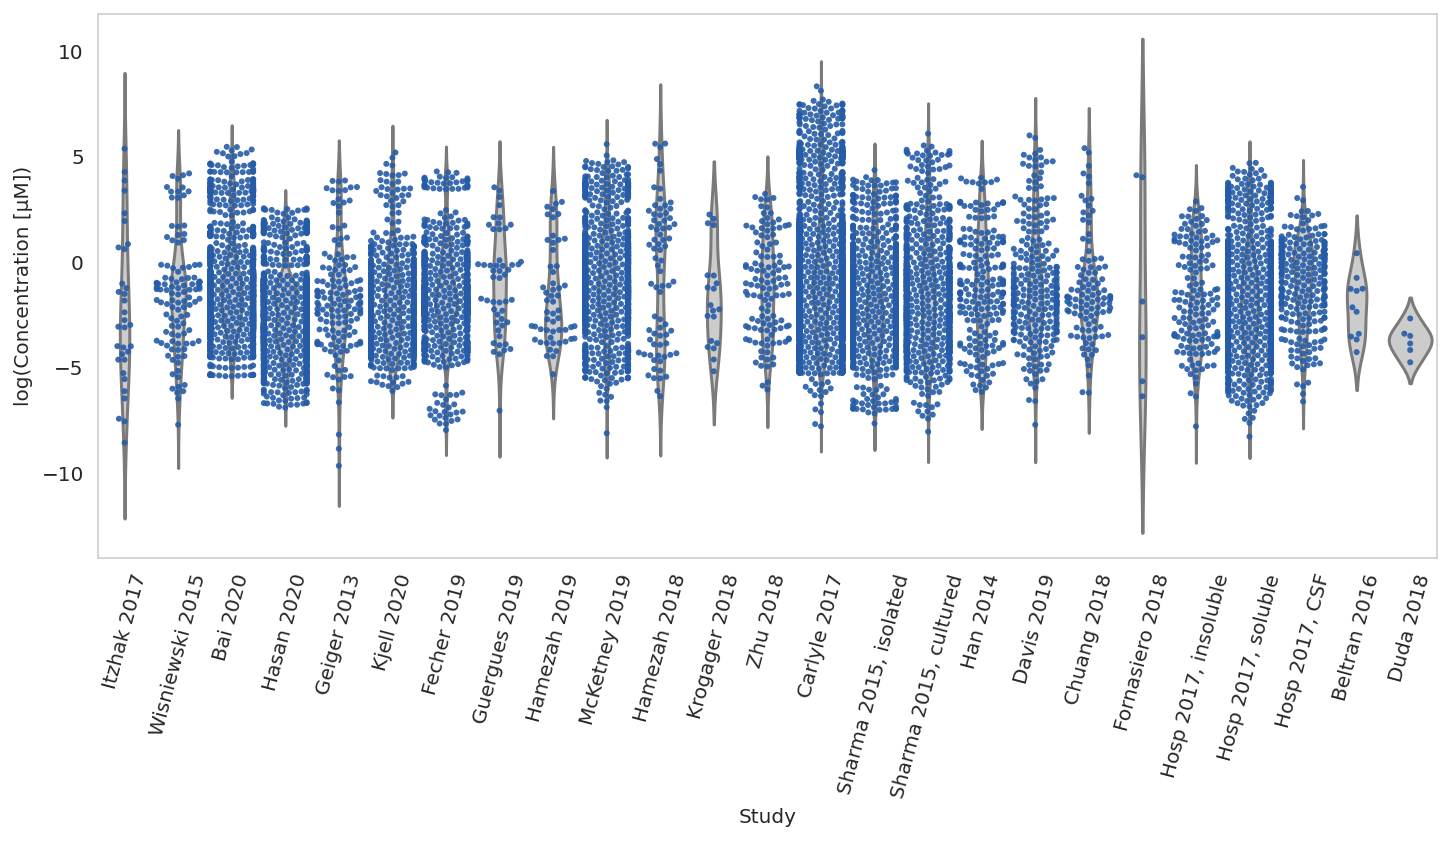

In [21]:
fig = plt.figure(figsize=(12,5))
sns.set_style("whitegrid", {'axes.grid' : False})

#ax = sns.boxplot(x="Study", y="log conc uM median norm", data=df_pep_ann, color='.8', width=0.3, fliersize=2)
ax = sns.violinplot(x="Study", y="log_conc_uM_medNorm", data=df_pep_annG, color='.8', inner=None)
ax = sns.swarmplot(x="Study", y="log_conc_uM_medNorm", data=df_pep_annG,size=3, alpha=0.9, color='#265ca7') #palette="Blues"jitter=0.05,)51a8c7  3c5580


plt.xticks(rotation=75)

ax.set_ylabel('log(Concentration [µM])')


#fig.savefig('../plots/S1F_peptides_studies.png', dpi=300, transparent=True)
#fig.savefig('../plots/S1F_peptides_studies.svg', transparent=True)


In [24]:
list(custom_dict.keys())

['Itzhak 2017',
 'Wisniewski 2015',
 'Bai 2020',
 'Hasan 2020',
 'Geiger 2013',
 'Kjell 2020',
 'Fecher 2019',
 'Guergues 2019',
 'Hamezah 2019',
 'McKetney 2019',
 'Hamezah 2018',
 'Krogager 2018',
 'Zhu 2018',
 'Carlyle 2017',
 'Sharma 2015, isolated',
 'Sharma 2015, cultured',
 'Han 2014',
 'Davis 2019',
 'Chuang 2018',
 'Fornasiero 2018',
 'Hosp 2017, insoluble',
 'Hosp 2017, soluble',
 'Hosp 2017, CSF',
 'Beltran 2016',
 'Duda 2018']

H =  442.66712271216966 p-value =  1.2372336052561884e-78


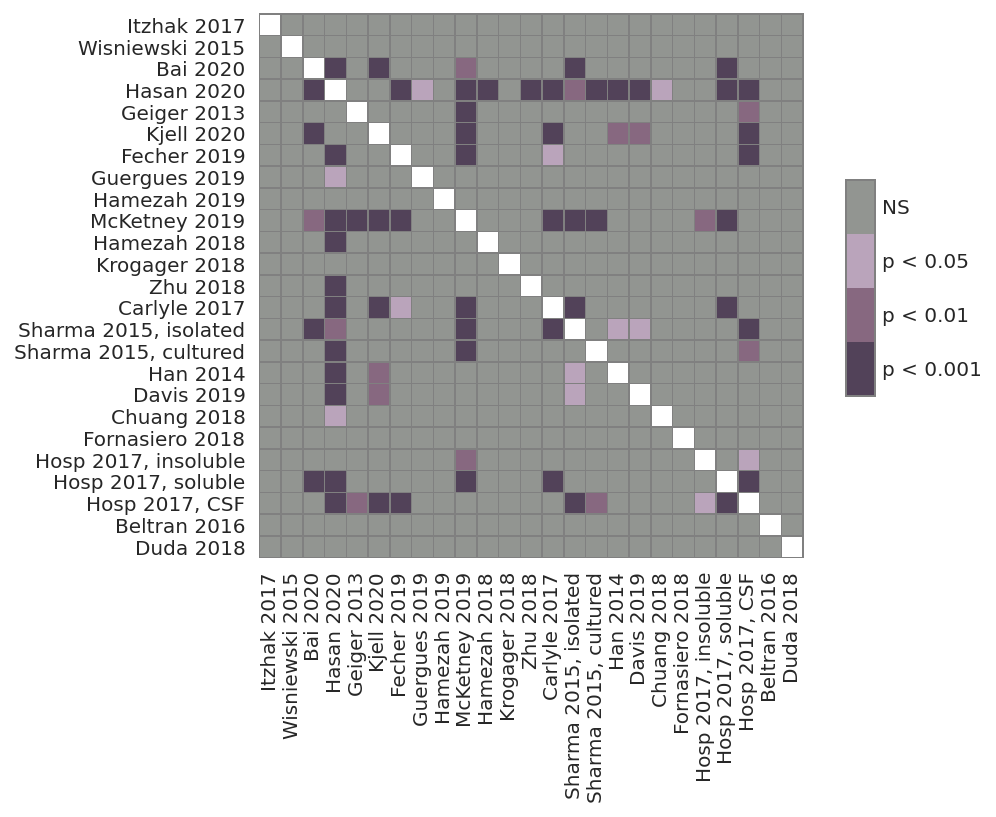

In [25]:
from numpy.random import seed
from numpy.random import randint
from scipy.stats import ks_2samp
from scipy.stats import levene
from scipy.stats import fligner
from scipy.stats import kruskal
import scikit_posthocs as sp

import scipy.stats as ss
from scipy.stats import mannwhitneyu

data = [df_pep_annG.loc[ids, 'log_conc_uM_medNorm'].values for ids in df_pep_annG.groupby('Study').groups.values()]
H, p = ss.kruskal(*data)
print("H = ", H, "p-value = ", p)


studies_log_conover_holm = sp.posthoc_conover(df_pep_annG, val_col='log_conc_uM_medNorm', group_col='Study', p_adjust = 'holm')


studies_log_conover_holm = studies_log_conover_holm[['Itzhak 2017',
 'Wisniewski 2015',
 'Bai 2020',
 'Hasan 2020',
 'Geiger 2013',
 'Kjell 2020',
 'Fecher 2019',
 'Guergues 2019',
 'Hamezah 2019',
 'McKetney 2019',
 'Hamezah 2018',
 'Krogager 2018',
 'Zhu 2018',
 'Carlyle 2017',
 'Sharma 2015, isolated',
 'Sharma 2015, cultured',
 'Han 2014',
 'Davis 2019',
 'Chuang 2018',
 'Fornasiero 2018',
 'Hosp 2017, insoluble',
 'Hosp 2017, soluble',
 'Hosp 2017, CSF',
 'Beltran 2016',
 'Duda 2018']]

studies_log_conover_holm = studies_log_conover_holm.reindex(custom_dict.keys())

studies_log_conover_holm.head()
fig,ax = plt.subplots(figsize=(5, 5))

cmap = ['1', '#929591','#524259','#876880', '#baa4bb']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
ax = sp.sign_plot(studies_log_conover_holm, **heatmap_args)

plt.show()



fig.savefig('../plots/S1G_peptides_studies_log_conover_holm_styled.svg', transparent=True)
fig.savefig('../plots/S1G_peptides_studies_log_conover_holm_styled.png',dpi=300, transparent=True)





In [26]:
with open('../data/peptides_names_uniprot_inData.txt', 'w') as f:
    for item in df_pep_annG['Uniprot_final'].unique():
        f.write("%s\n" % item)